### A notebook to extract and present current status regarding BiGG and Rhea

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import networkx as nx
import requests
import io
from pyvis.network import Network

In [25]:
bigg = pd.read_csv("bigg_transported_mets.tsv", sep="t", header=None, skiprows=[0], usecols=[1,2,3])
rhea = pd.read_csv("rheaTransports.tsv", sep="t", header=None, skiprows=[0], usecols=[1,3,4,5,6])
bigg.columns = ["bigg_id", "ID", "rhea"]
rhea.columns = ["rid", "cid", "ec", "accession", "name"]
bigg["rhea"] = bigg["rhea"].str.replace(r'(?i)chebi', 'CHEBI', regex=True)

In [42]:
common_chebi = pd.merge(bigg, rhea, left_on="rhea", right_on="accession", how="inner")
common_chebi[["bigg_id", "ID", "rhea", "ec", "name"]].head()

,bigg_id,ID,rhea,ec,name
0,h,MNXM1,CHEBI:15378,"7.1.1.9,",H(+)
1,h,MNXM1,CHEBI:15378,"7.1.1.8,",H(+)
2,h,MNXM1,CHEBI:15378,"7.1.3.1,",H(+)
3,h,MNXM1,CHEBI:15378,"7.1.2.1,",H(+)
4,h,MNXM1,CHEBI:15378,"7.2.4.3,",H(+)


An overview of the distribution of EC numbers from the Rhea data

C:\Users\landr\AppData\Local\Temp\ipykernel_23712\569167022.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  rhea = rhea[~rhea["ec"].str.contains(r"^(nan|nan,|\[nan\])$", case=False, na=False)]


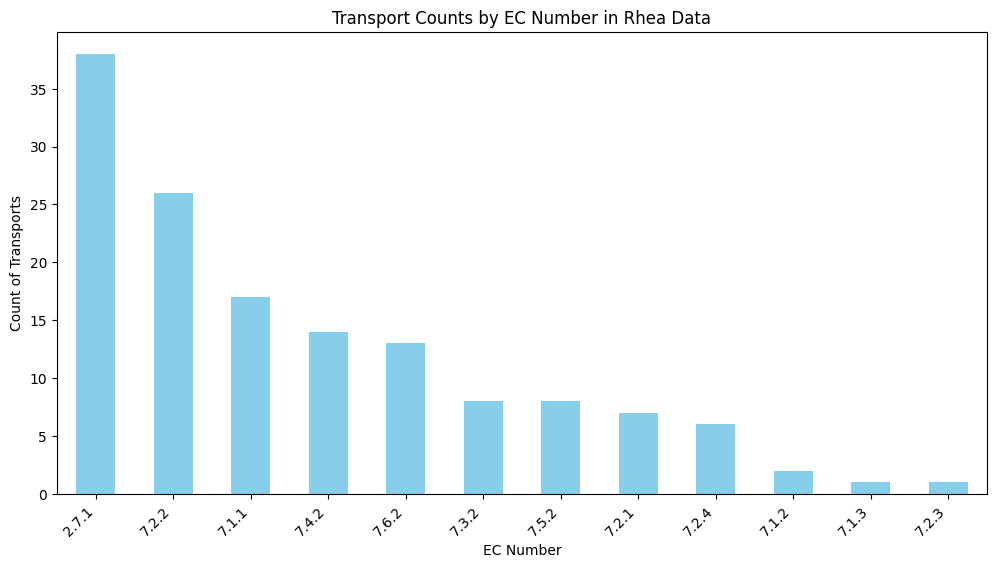

In [28]:
rhea = rhea[~rhea["ec"].str.contains(r"^(nan|nan,|\[nan\])$", case=False, na=False)]
rhea["ec"] = rhea["ec"].str.replace(r"[()']", "", regex=True)
rhea["ec_group"] = rhea["ec"].str.extract(r"^(\d+\.\d+\.\d+)")[0]
rhea = rhea.dropna(subset=["ec_group"])

ec_counts = rhea["ec_group"].value_counts()

plt.figure(figsize=(12, 6))
ec_counts.plot(kind="bar", color="skyblue")
plt.xlabel("EC Number")
plt.ylabel("Count of Transports")
plt.title("Transport Counts by EC Number in Rhea Data")
plt.xticks(rotation=45, ha="right")
plt.show()

Overlap between Rhea and BiGG

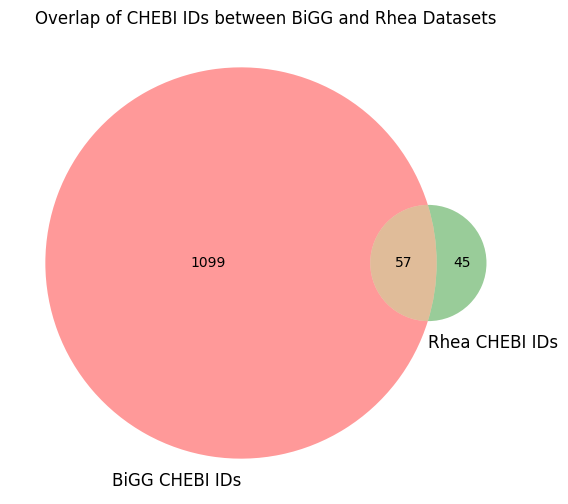

In [34]:
bigg_chebi_ids = set(bigg["rhea"].unique())
rhea_chebi_ids = set(rhea["accession"].unique())

plt.figure(figsize=(8, 6))
venn = venn2([bigg_chebi_ids, rhea_chebi_ids], ("BiGG CHEBI IDs", "Rhea CHEBI IDs"))
plt.title("Overlap of CHEBI IDs between BiGG and Rhea Datasets")
plt.show()

Obtaining data from Rhea online

In [35]:
RHEA_URL = "https://www.rhea-db.org/rhea?"
query = "transport:yes"
response = requests.get(RHEA_URL, params={"query": query, "format": "tsv", "columns": "rhea-id,ec,equation,go,chebi-id"})
df = pd.read_csv(io.StringIO(response.text), sep="\t")
df

,Reaction identifier,EC number,Equation,Gene Ontology,ChEBI identifier
0,RHEA:23972,EC:7.2.4.5,(2E)-glutaconyl-CoA + H(+) + Na(+)(in) = (2E)-...,GO:0018801 glutaconyl-CoA decarboxylase activity,CHEBI:57353;CHEBI:15378;CHEBI:29101;CHEBI:5733...
1,RHEA:24440,EC:7.3.2.1,ATP + H2O + phosphate(out) = ADP + H(+) + 2 ph...,GO:0015415 ATPase-coupled phosphate ion transm...,CHEBI:30616;CHEBI:15377;CHEBI:43474;CHEBI:4562...
2,RHEA:25792,EC:7.2.2.8,ATP + Cu(+)(in) + H2O = ADP + Cu(+)(out) + H(+...,GO:0140581 P-type monovalent copper transporte...,CHEBI:30616;CHEBI:49552;CHEBI:15377;CHEBI:4562...
3,RHEA:27814,NaN,acetate(in) + Na(+)(in) = acetate(out) + Na(+)...,NaN,CHEBI:30089;CHEBI:29101
4,RHEA:27926,NaN,UMP(in) = UMP(out),NaN,CHEBI:57865
...,...,...,...,...,...
1491,RHEA:22020,EC:7.3.2.5,ATP + H2O + molybdate(out) = ADP + H(+) + moly...,GO:0015412 ABC-type molybdate transporter acti...,CHEBI:30616;CHEBI:15377;CHEBI:36264;CHEBI:4562...
1492,RHEA:22044,EC:7.2.2.19,ATP + H(+)(in) + H2O + K(+)(out) = ADP + 2 H(+...,GO:0008900 P-type potassium:proton transporter...,CHEBI:30616;CHEBI:15378;CHEBI:15377;CHEBI:2910...
1493,RHEA:22132,EC:7.5.2.1,ATP + D-maltose(out) + H2O = ADP + D-maltose(i...,GO:0015423 ABC-type maltose transporter activity,CHEBI:30616;CHEBI:17306;CHEBI:15377;CHEBI:4562...
1494,RHEA:22148,EC:7.1.1.6,a plastoquinol + 2 H(+)(in) + 2 oxidized [plas...,GO:0009496 plastoquinol--plastocyanin reductas...,CHEBI:62192;CHEBI:15378;CHEBI:29036;CHEBI:1775...


Building a network on substrates and their corresponding transporters

In [43]:
net = Network(directed=True, notebook=True, height="500px", width="1200px", cdn_resources="remote")

added_nodes = set()
df_filtered = df.dropna(subset=["EC number"])

for i, row in df_filtered.iterrows():
    reaction = row["Reaction identifier"]
    net.add_node(reaction, shape="box", label=row["EC number"], color="lightgreen")
    
    left, right = row["Equation"].split(" = ")
    
    for compound in left.split(" + "):
        if compound not in added_nodes:
            net.add_node(compound, physics=False)
            added_nodes.add(compound)
        net.add_edge(compound, reaction, color="coral", physics=False)
        
    for compound in right.split(" + "):
        if compound not in added_nodes:
            net.add_node(compound, physics=False)
            added_nodes.add(compound)
        net.add_edge(reaction, compound, color="coral", physics=False)

net.set_options("""
{
  "physics": {
    "enabled": true,
    "barnesHut": {
      "gravitationalConstant": -2000,
      "springLength": 200,
      "springConstant": 0.02
    },
    "minVelocity": 0.75,
    "maxVelocity": 50
  },
  "smooth": {
    "enabled": false
  },
  "manipulation": {
    "enabled": false
  },
  "nodes": {
    "font": {
      "size": 12
    },
    "scaling": {
      "min": 10,
      "max": 30
    },
    "borderWidth": 1
  },
  "edges": {
    "width": 2,
    "smooth": {
      "enabled": true,
      "type": "continuous"
    }
  }
}
""")

net.show("network_rhea.html")

network_rhea.html


Finding all neighbors to each node

In [38]:
rhea_to_ec = df.set_index("Reaction identifier")["EC number"].to_dict()

substrate_to_transporter_neighbors = {}
transporter_to_substrate_neighbors = {}

for node in net.nodes:
    cleaned_neighbors = {
        ec for neighbor in net.neighbors(node["id"])
        for ec in rhea_to_ec.get(neighbor, neighbor).split(";")
    }
    
    new_key = rhea_to_ec.get(node["id"], node["id"])
    
    if new_key.startswith("EC"):
        transporter_to_substrate_neighbors[new_key] = cleaned_neighbors
    else:
        substrate_to_transporter_neighbors[new_key] = cleaned_neighbors

Writing out all neighbors to ECs and substrates in seperate files

In [39]:
def write_dict_to_tsv(dictionary, file_name, node_title):
    rows = []
    for key, neighbors in dictionary.items():
        rows.append([key, ", ".join(neighbors)])

    df = pd.DataFrame(rows, columns=[node_title, "Neighbors"])
    df.to_csv(file_name, sep="\t", index=False)

write_dict_to_tsv(substrate_to_transporter_neighbors, "substrate_to_transporter_neighbors.tsv", "Substrate")
write_dict_to_tsv(transporter_to_substrate_neighbors, "transporter_to_substrate_neighbors.tsv", "EC number")

Overlap between Rhea (online) and BiGG

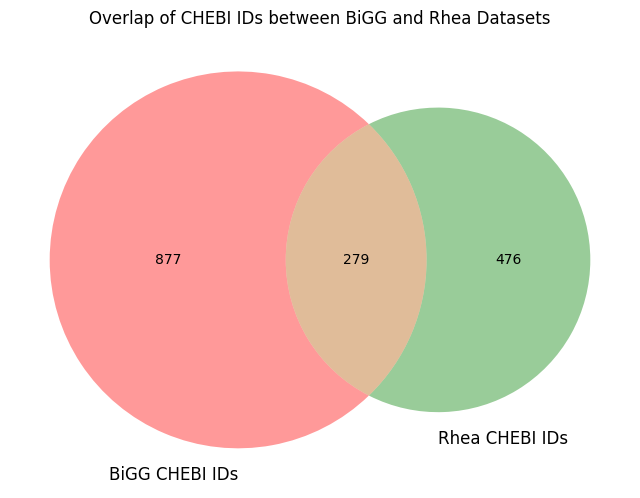

In [40]:
chebi_column = df["ChEBI identifier"]
all_chebi_ids = chebi_column.str.split(";").explode()
rhea_chebi_ids_2 = set(all_chebi_ids)

bigg_chebi_ids = set(bigg["rhea"].unique())

plt.figure(figsize=(8, 6))
venn = venn2([bigg_chebi_ids, rhea_chebi_ids_2], ("BiGG CHEBI IDs", "Rhea CHEBI IDs"))
plt.title("Overlap of CHEBI IDs between BiGG and Rhea Datasets")
plt.show()
